## Link do Github : <https://github.com/BIRDRED/ProjetoKobe>

# Imports

In [23]:
import os
import warnings
import sys

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn import linear_model, preprocessing, metrics, model_selection
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from pycaret.classification import *
import pycaret.classification as pc
from pandas import Series, DataFrame

import seaborn as sn

if 'inline_rc' not in dir():
    inline_rc = dict(mpl.rcParams)

SEED = 10
np.random.seed(SEED)

In [24]:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax


In [25]:
df_kobe = pd.read_csv('../Data/Raw/kobe_dataset.csv',sep=',')

In [26]:
df_kobe.isnull().values.any()

True

In [27]:
df_kobe['shot_made_flag'].isnull().sum()

5000

In [28]:
df_kobe = df_kobe.dropna(subset=['shot_made_flag'])

In [29]:
df_kobe.insert(len(df_kobe.columns), 'time_remaining',
               Series(df_kobe.minutes_remaining*60 + df_kobe.seconds_remaining)
              )

In [30]:
df_kobe_2p = df_kobe[df_kobe['shot_type'] == '2PT Field Goal']
df_kobe_3p = df_kobe[df_kobe['shot_type'] == '3PT Field Goal']

In [37]:
df_kobe_2p.loc_y

1          0
2        135
3        175
4          0
5        -11
        ... 
30690    100
30691      0
30692     48
30694    166
30696     72
Name: loc_y, Length: 20285, dtype: int64

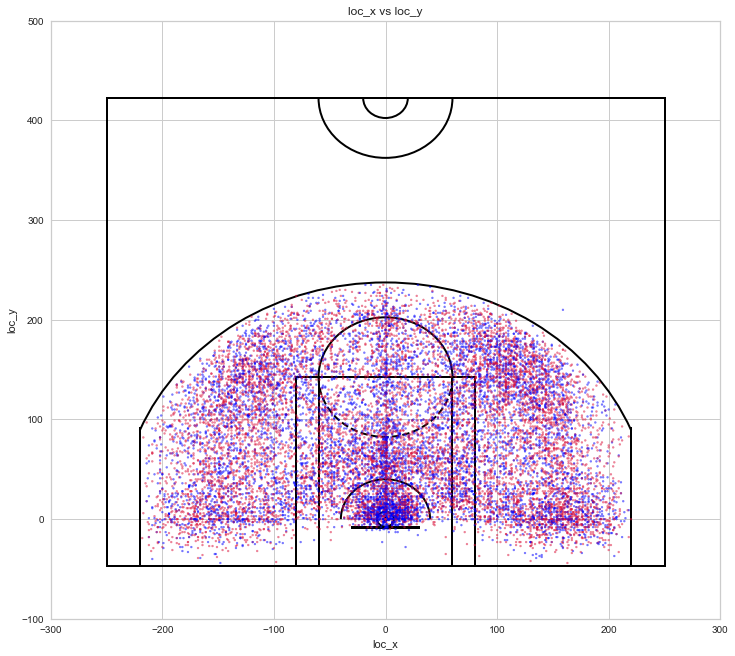

In [53]:
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
colors = np.where(df_kobe_2p['shot_made_flag'] == 0 , 'Crimson','blue');
colors.shape
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.title('loc_x vs loc_y')
plt.xlabel('loc_x')
plt.ylabel('loc_y')
plt.scatter(df_kobe_2p.loc_x,df_kobe_2p.loc_y, color=colors, s=4, alpha=0.5)
plt.show()

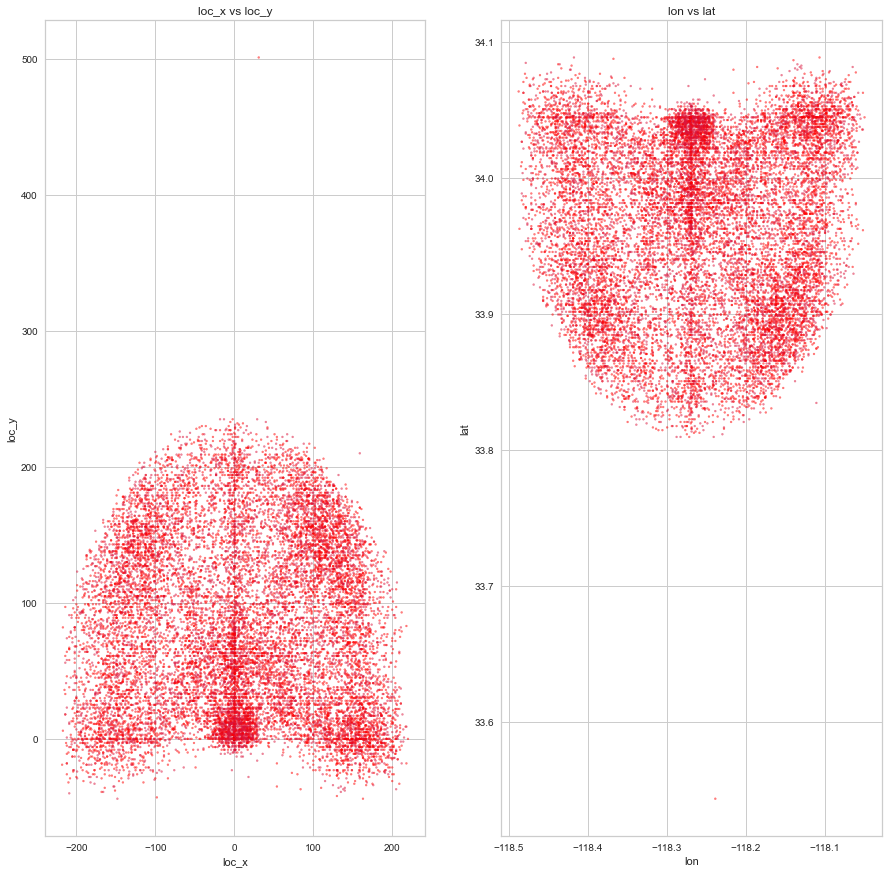

In [46]:
plt.figure(figsize=(15,15))
draw_court(outer_lines=True)
colors = np.where(df_kobe_2p['shot_made_flag'] == 0 , 'red','Crimson');
colors.shape
plt.subplot(121)
plt.title('loc_x vs loc_y')
plt.xlabel('loc_x')
plt.ylabel('loc_y')
plt.scatter(df_kobe_2p.loc_x,df_kobe_2p.loc_y, color=colors, s=4 , alpha=0.5)

plt.subplot(122)
plt.title('lon vs lat')
plt.xlabel('lon')
plt.ylabel('lat')
plt.scatter(df_kobe_2p.lon,df_kobe_2p.lat, color=colors, s=4, alpha=0.5)

In [12]:
df_kobe['shot_zone_range'].value_counts()

Less Than 8 ft.    7857
16-24 ft.          6907
8-16 ft.           5580
24+ ft.            5281
Back Court Shot      72
Name: shot_zone_range, dtype: int64

In [13]:
df_kobe.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id,time_remaining
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2,622
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3,465
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4,412
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5,379
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,0,2000-01,32,14,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6,572


In [14]:
df_kobe['combined_shot_type'].value_counts()

Jump Shot    19710
Layup         4532
Dunk          1056
Tip Shot       152
Hook Shot      127
Bank Shot      120
Name: combined_shot_type, dtype: int64

In [15]:
df_kobe['shot_zone_range'].value_counts()

Less Than 8 ft.    7857
16-24 ft.          6907
8-16 ft.           5580
24+ ft.            5281
Back Court Shot      72
Name: shot_zone_range, dtype: int64

In [16]:
groups = df_kobe.groupby('shot_zone_range')
for column,frame in groups:
    print('column: {0}, frame:{1}' .format(column,len(frame)))

column: 16-24 ft., frame:6907
column: 24+ ft., frame:5281
column: 8-16 ft., frame:5580
column: Back Court Shot, frame:72
column: Less Than 8 ft., frame:7857


In [32]:
np.linspace(0,1, len(groups))

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

<Figure size 360x720 with 0 Axes>

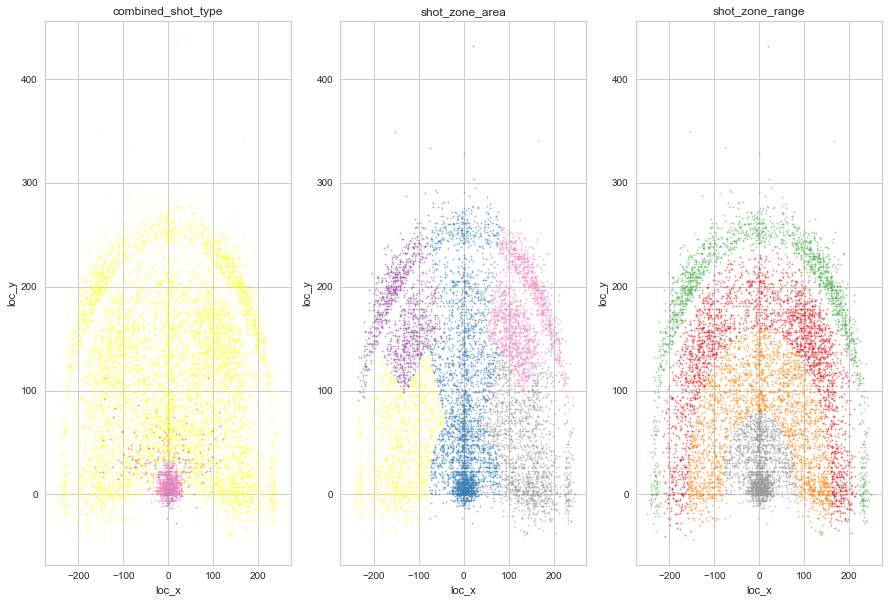

In [25]:
import matplotlib.cm as cm
plt.figure(figsize=(5,10))

def grouped_plot(feature):
    groups = df_kobe[df_kobe['shot_made_flag']==1].groupby(feature)
    colors = cm.Set1(np.linspace(0,1,len(groups)))
    for g, c in zip(groups,colors):
        plt.scatter(g[1].loc_x,g[1].loc_y,color=c, s=2, alpha=0.5)

plt.figure(figsize=(15,10))

plt.subplot(131)
plt.title('combined_shot_type')
plt.xlabel('loc_x')
plt.ylabel('loc_y')
grouped_plot('combined_shot_type')

plt.subplot(132)
plt.title('shot_zone_area')
plt.xlabel('loc_x')
plt.ylabel('loc_y')
grouped_plot('shot_zone_area')

plt.subplot(133)
plt.title('shot_zone_range')
plt.xlabel('loc_x')
plt.ylabel('loc_y')
grouped_plot('shot_zone_range')

<Figure size 864x792 with 0 Axes>

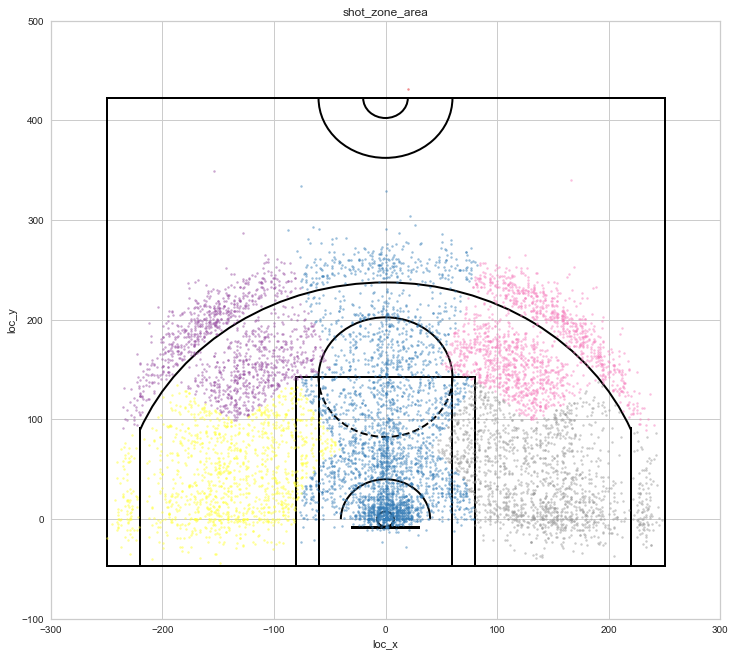

In [64]:
import matplotlib.cm as cm
plt.figure(figsize=(12,11))

def grouped_plot(feature):
    groups = df_kobe[df_kobe['shot_made_flag']==1].groupby(feature)
    colors = cm.Set1(np.linspace(0,1,len(groups)))
    for g, c in zip(groups,colors):
        plt.scatter(g[1].loc_x,g[1].loc_y,color=c, s=4, alpha=0.5)

plt.figure(figsize=(12,11))
draw_court(outer_lines=True)

plt.title('shot_zone_area')
plt.xlim(-300,300)
plt.ylim(-100,500)
plt.xlabel('loc_x')
plt.ylabel('loc_y')
grouped_plot('shot_zone_area')


In [12]:
mpl.rcParams.update(inline_rc)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)
lines = {'linewidth' : 3}
mpl.rc('lines', **lines)

In [13]:
registered_model_name = 'modelo_projeto_kobe'
min_precision = 0.7
model_version = -1 # recuperar a ultima versao
nexamples = 4

# Diagrama do Pipeline do Projeto

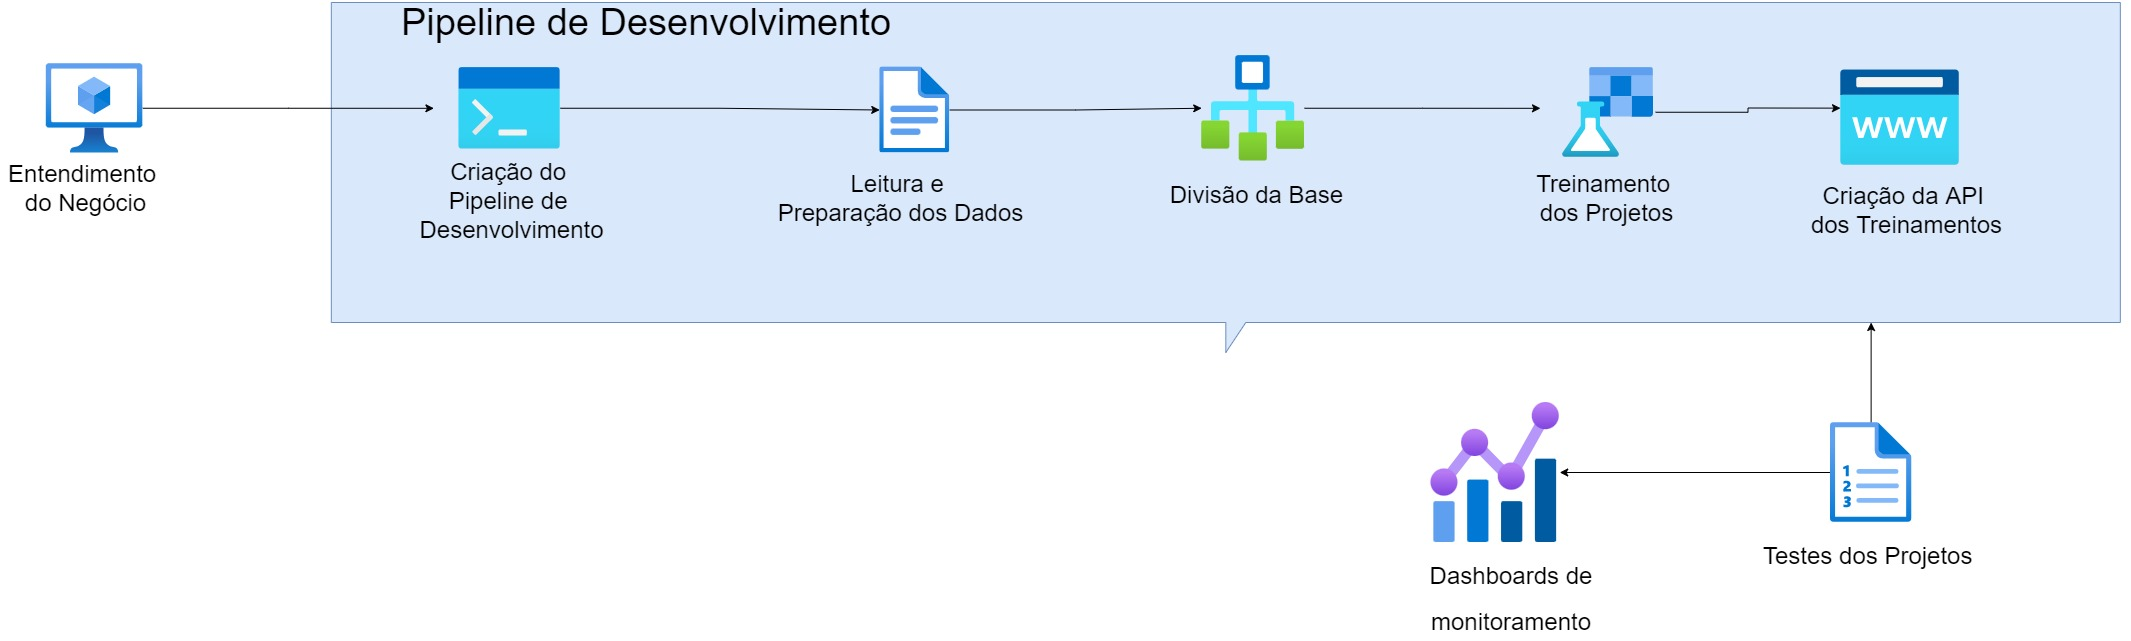

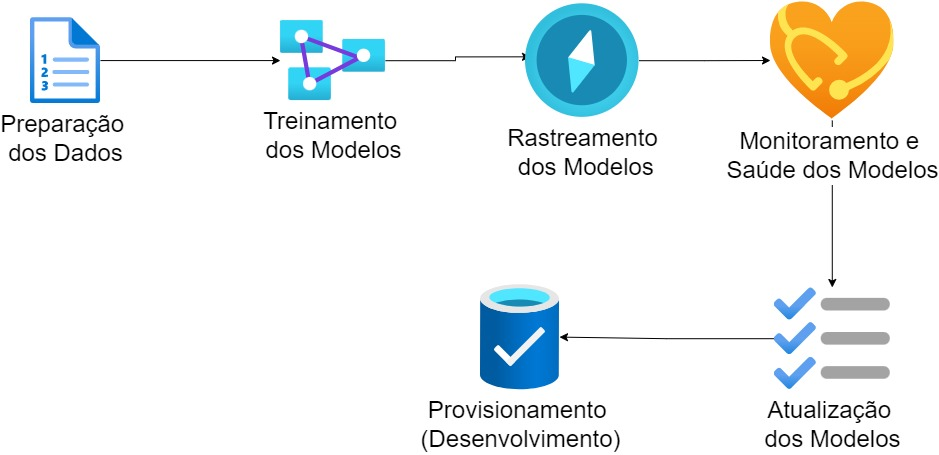

# Pipeline de Desenvolvimento dos Arremessos Kobe Bryant

Neste momento torna-se necessário variar os pipelines de forma que poderemos aproveitar os dados estruturados para avaliar e verificar se os experimentos foram bem feitos e se pode haver uma melhoria nos dados descritos.

Para isso é preciso criar um pipeline para ter um referencial dos modelos criados e guardar os dados dos modelos. Podemos ter os artefatos,métricas e parametros utilizados e testar diferentes modelos para achar o melhor modelo para validar os dados e utilizá-los da melhor maneira.

É possível através deste pipeline separarmos o que será utilizado em desenvolvimento e em seguida colocar em produção os dados utilizados.

Após a validação dos modelos colocados em desenvolvimento, pode ser colocado o modelo em produção para que possa ser utilizado nas APIs selecionadas

## Inicio dos Pipelines 

In [28]:
#!mlflow ui --backend-store-uri sqlite:///mlruns.db

In [14]:
# Para usar o sqlite como repositorio
mlflow.set_tracking_uri("sqlite:///../mlruns.db")

experiment_name = 'Projeto Black Mamba'
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment(experiment_id)
experiment_id = experiment.experiment_id

## Pipeline para a Preparação dos Dados Kobe Bryant

In [15]:
# COLOCAR RUN DE LEITURA DE DADOS
# PARAMETROS: top_features,
# METRICS: SHAPE de cada base de dados
# ARTIFACTS: nenhum

with mlflow.start_run(experiment_id=experiment_id, run_name = 'PreparacaoDados'):
    df_kobe = pd.read_csv('../Data/Raw/kobe_dataset.csv',sep=',')
    kobe_target_col = 'shot_made_flag'
    df_kobe_2p = df_kobe[df_kobe['shot_type'] == '2PT Field Goal']
    df_kobe_3p = df_kobe[df_kobe['shot_type'] == '3PT Field Goal']
    df_kobe_2p = df_kobe_2p[['lat','lon','minutes_remaining','period', 'playoffs','shot_distance','shot_made_flag']]
    df_kobe_3p = df_kobe_3p[['lat','lon','minutes_remaining','period', 'playoffs','shot_distance','shot_made_flag']]
    df_kobe_2p = df_kobe_2p.dropna()
    df_kobe_3p = df_kobe_3p.dropna()
    test_size = 0.2
    
    # Separar parte para compor a base de operacao
    xtrain, data_operation, ytrain, ytest = model_selection.train_test_split(df_kobe_2p, 
                                                                            df_kobe_2p[kobe_target_col],
                                                                            test_size=test_size)
    
    data_novelty = df_kobe_3p.copy()
    xtrain[kobe_target_col]      = ytrain
    data_operation[kobe_target_col] = ytest
    
    xtrain.to_parquet('../Data/Processed/data_filtered.parquet')
    data_operation.to_parquet('../Data/Processed/base_8020.parquet')
    data_novelty.to_parquet('../Data/Processed/base_kobe_novidade.parquet')

    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("test_size", test_size)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("data_dev", df_kobe_2p.shape[0])
    mlflow.log_metric("data_operation", data_operation.shape[0])
   
    
mlflow.end_run()

print('== Bases de Dados ==')
print(f'xtrain {xtrain.shape}')
print(f'data_operation {data_operation.shape}')
print(f'Columns: {df_kobe_2p.columns}')

== Bases de Dados ==
xtrain (16228, 7)
data_operation (4057, 7)
Columns: Index(['lat', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'shot_distance', 'shot_made_flag'],
      dtype='object')


In [10]:
data_operation['shot_made_flag'].value_counts()

0.0    2087
1.0    1970
Name: shot_made_flag, dtype: int64

## Pipeline para os Treinamentos dos Dados Kobe Bryant

**IMPORTANCIA DAS FERRAMENTAS NO TREINAMENTO**

**Streamlit** - Pode ser utilizado para a criação dos Dashboards com a utilização do treinamento pra verificar de maneira visual as diferenças da base entretanto nesse exemplo não é utilizado

**MLFlow**  - É utilizado para registrar os experimentos e treinamentos da base dos dados além de salvar artefatos, parametros e métricas 

**PyCaret** - Verifica o melhor modelo da base através dos parametros a serem utilizados, gera os artefatos e além das bases treinados

**Scikit-Learn** - É utiliado para calcular as métricas geradas no treinamento

### Pipeline para o Treinamento

In [26]:
# COLOCAR RUN DE TREINAMENTO DE MODELOS
# PARAMETROS: fold_strategy, fold, model_name, registered_model_name, cross_validation
# METRICS: auto sklearn
# ARTIFACTS: plots

with mlflow.start_run(experiment_id=experiment_id, run_name = 'Treinamento'):
    
    models = ['lr','dt']
    probability_threshold = 0.5
    cross_validation = True
    fold_strategy = 'stratifiedkfold',
    fold = 10

    # train/test
    s = pc.setup(data = xtrain, 
                 target = kobe_target_col,
                 test_data = data_operation,
                 silent = True,
                 fold_strategy = 'stratifiedkfold',
                 fold = fold,
                 log_experiment = True, 
                 experiment_name = experiment_name, 
                 log_plots = True,
                 verbose=False
                )
    #bestmodel = pc.create_model(model_name,cross_validation = cross_validation,probability_threshold=probability_threshold)
    add_metric('logloss', 'Log Loss', log_loss, greater_is_better = False)
    bestmodel = pc.compare_models(include = models, sort='f1',n_select=2)
    

    
    # Log do run, e nao do modelo respectivo
    classification_plots = [ 'auc','pr','confusion_matrix',
    #                          'error', 'class_report', 
                            'threshold',
                             'learning','vc','feature','tree'
                           ]
    for plot_type in classification_plots:
        print('=> Aplicando plot ', plot_type)
        try:
            artifact = pc.plot_model(bestmodel[0], scale=10,plot=plot_type, save=True, use_train_data=False)
            mlflow.log_artifact(artifact)
        except:
            print('=> Nao possivel plotar: ', plot_type )
            continue

    pred_holdout = pc.predict_model(bestmodel[0])
    #pred_holdout_sec = pc.predict_model(bestmodel[1])
    #mlflow.log_metrics({"log loss Arvore":  log_loss(ytest, pred_holdout['Label'].astype(float)),
    #                   "f1 Arvore": f1_score(ytest, pred_holdout['Label'].astype(float)),
    #                   })
    
    #mlflow.log_metrics({"log loss LR":  log_loss(ytest, pred_holdout_sec['Label']),
    #                   "f1 LR": f1_score(ytest, pred_holdout_sec['Label'].astype(float)),
    #                   })
    pc.save_model(bestmodel[0], f'../Data/Modeling/{registered_model_name}') 
    # Carrega novamente o pipeline + bestmodel
    model_pipe = pc.load_model(f'../Data/Modeling/{registered_model_name}')


mlflow.end_run()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


=> Nao possivel plotar:  tree


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss
0,Decision Tree Classifier,0.5354,0.5101,0.5861,0.5151,0.5483,0.0741,0.0747,16.0479


Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


In [24]:
pc.plot_model?

Signature:
pc.plot_model(
    estimator,
    plot: str = 'auc',
    scale: float = 1,
    save: bool = False,
    fold: Union[int, Any, NoneType] = None,
    fit_kwargs: Union[dict, NoneType] = None,
    plot_kwargs: Union[dict, NoneType] = None,
    groups: Union[str, Any, NoneType] = None,
    use_train_data: bool = False,
    verbose: bool = True,
    display_format: Union[str, NoneType] = None,
) -> str
Docstring:
This function analyzes the performance of a trained model on holdout set.
It may require re-training the model in certain cases.

Example
-------
>>> from pycaret.datasets import get_data
>>> juice = get_data('juice')
>>> from pycaret.classification import *
>>> exp_name = setup(data = juice,  target = 'Purchase')
>>> lr = create_model('lr')
>>> plot_model(lr, plot = 'auc')


estimator: scikit-learn compatible object
    Trained model object


plot: str, default = 'auc'
    List of available plots (ID - Name):

    * 'auc' - Area Under the Curve
    * 'threshold' - Discri

### Artefatos

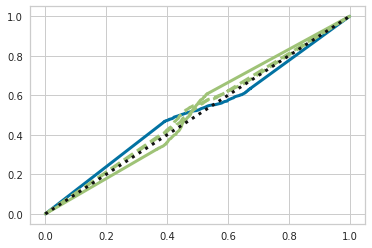

*AUC* -  Verifica a classificação da base de acordo com os dados utilizados


-----------------------------------------------------------------

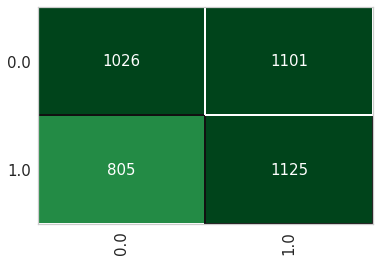

*Matriz de Confusão* - Verifica a matriz com os verdadeiros positivos e negativos  e os falsos negativos e positivos. 
Sendo os números menores condizentes com os valores da matriz de confusão

-----------------------------------------------------------------

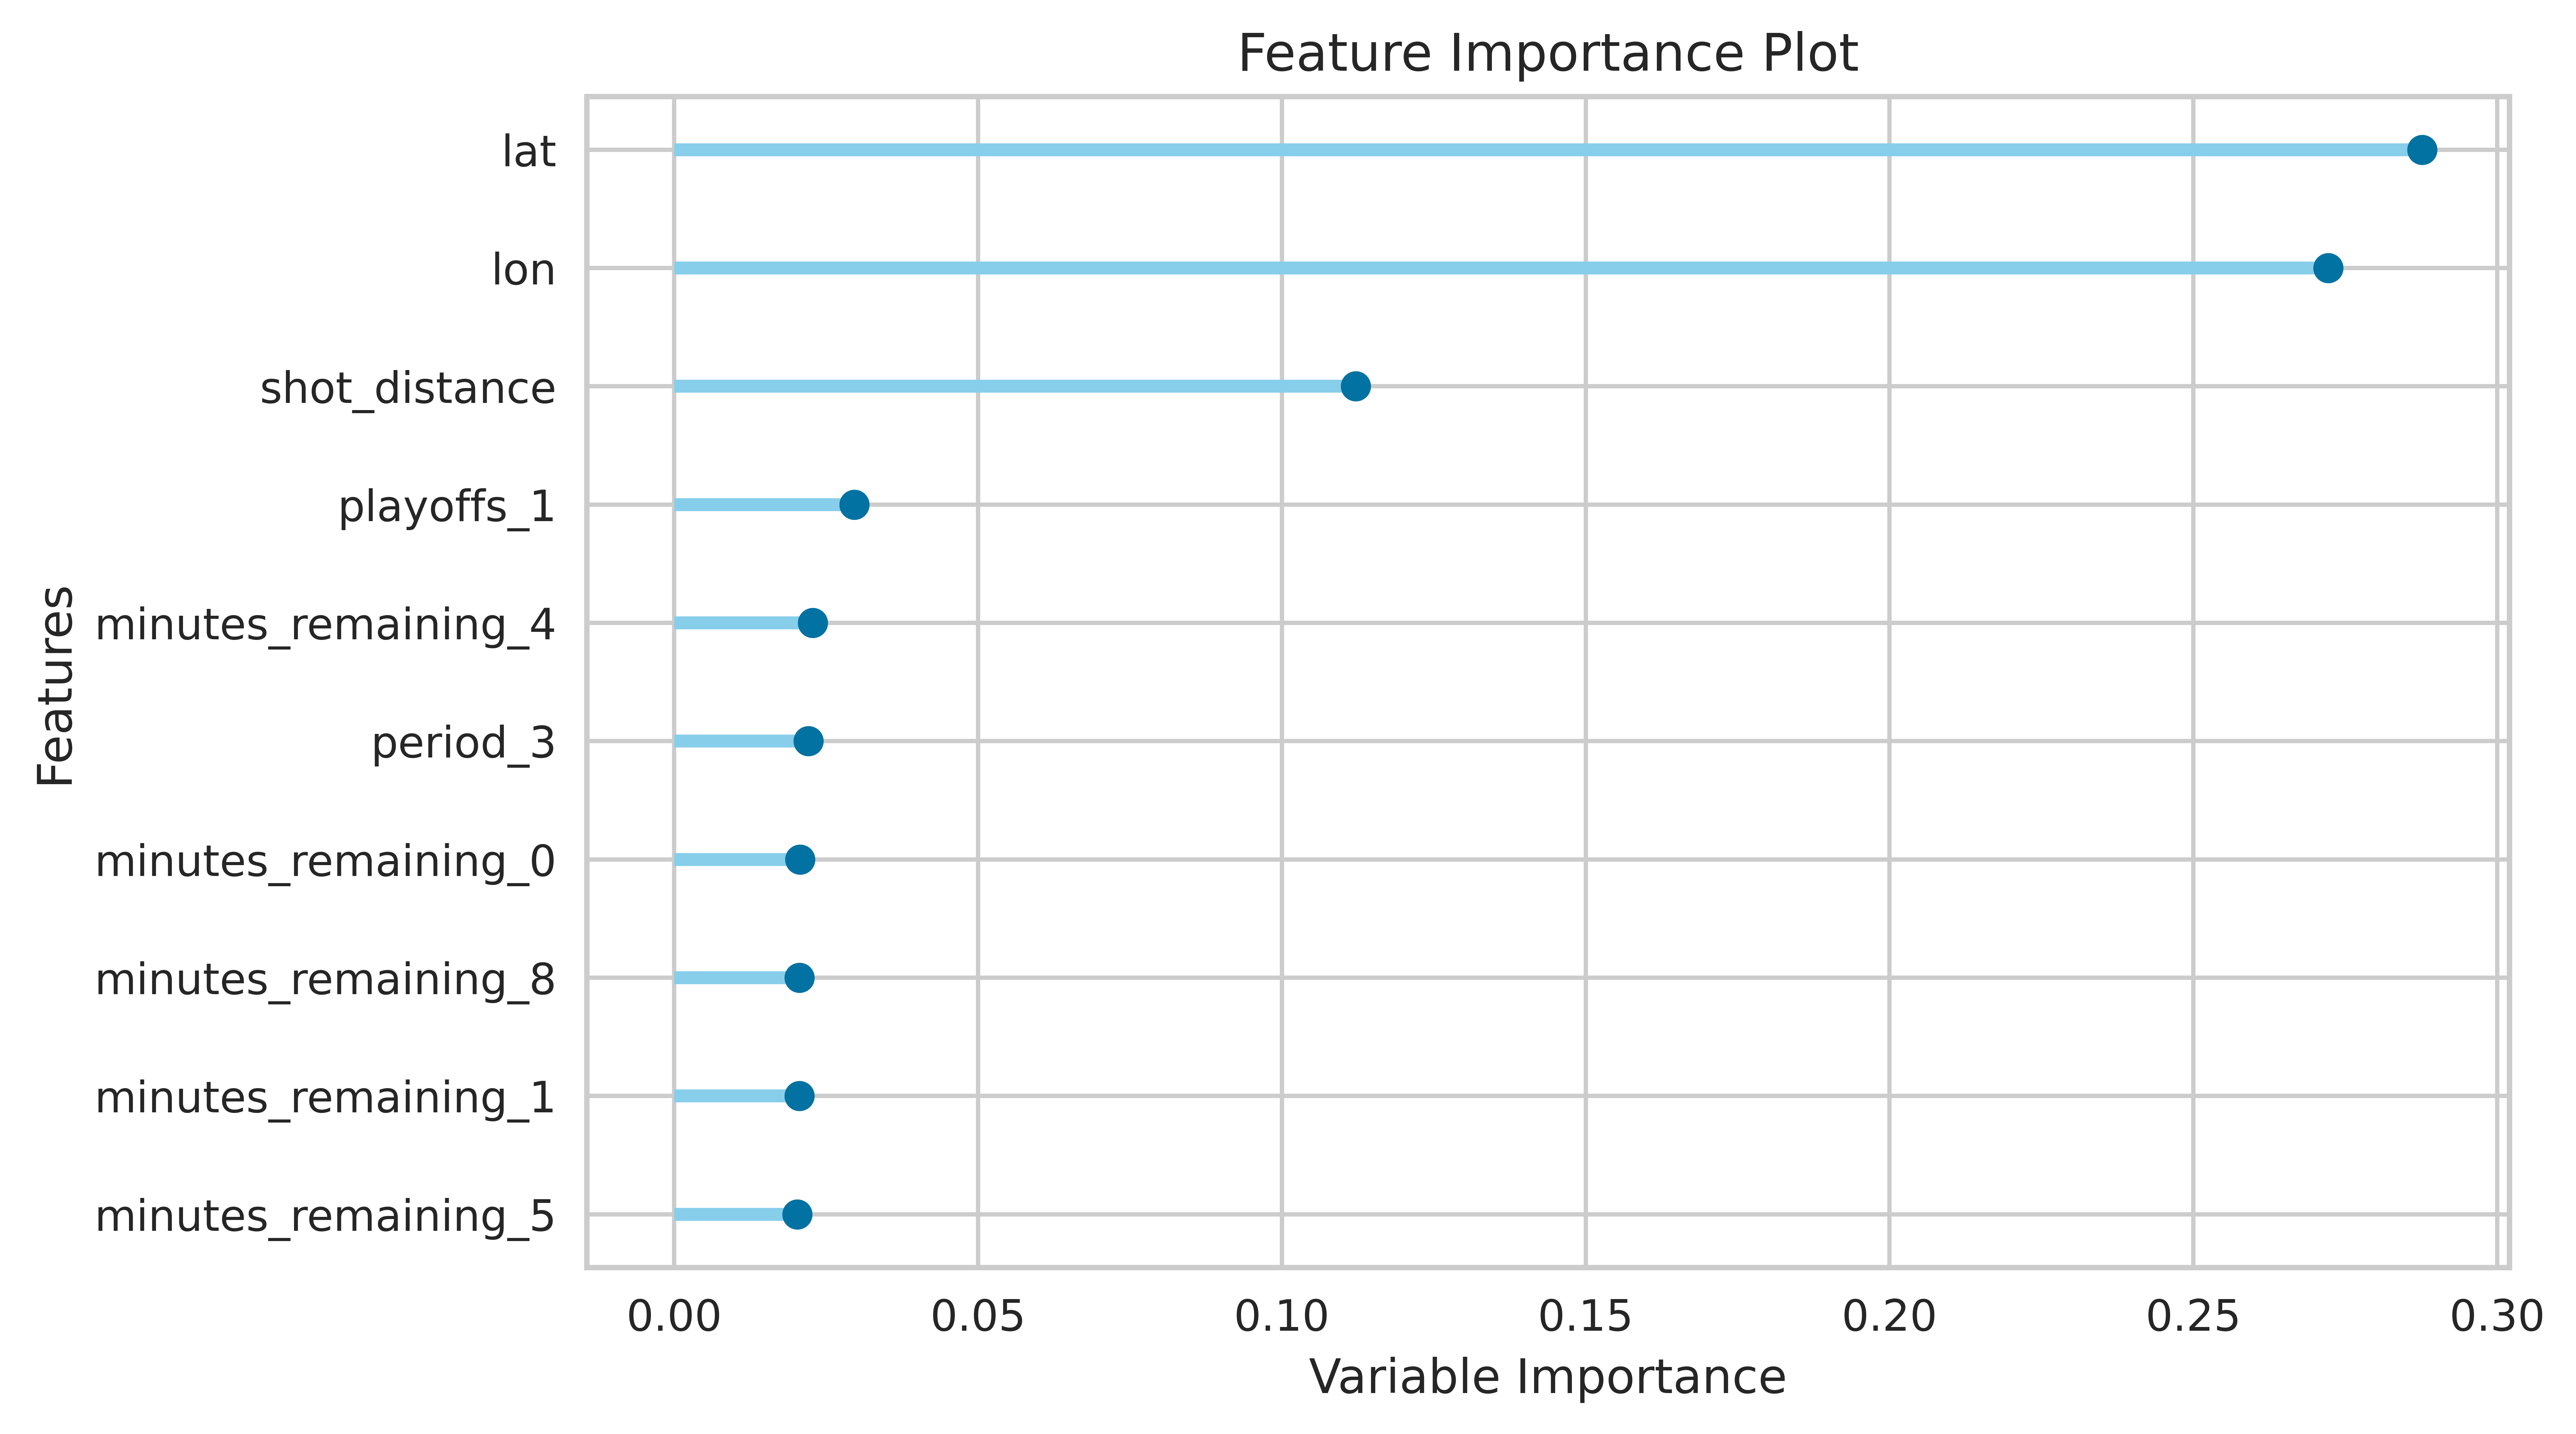

*Variaveis Importantes* -  Fornece a importancia das variaveis para a classificação dos dados

-----------------------------------------------------------------

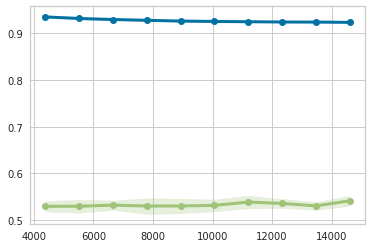

*Curva de Aprendizado* - Conforme o aumento da base se verifica o quanto há de aprendizado desta base no momento que está sendo utilizado

-----------------------------------------------------------------

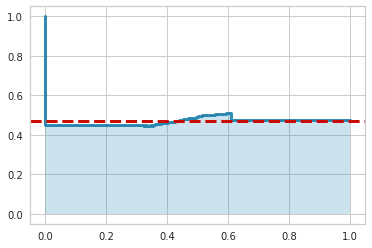

*Curva de precisão-recall* - A curva de precisão serve para detectar a quantidade de itens negativos para a base e os modelos positivos das bases 

-----------------------------------------------------------------

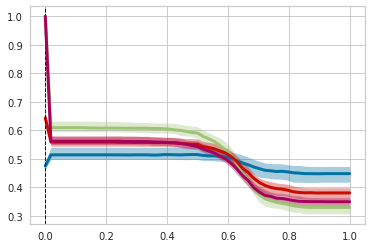

*Threshold* - Verifica com os verdadeiros positivos e negativos  e os falsos negativos e positivos de acordo com o tamanho da base

-----------------------------------------------------------------

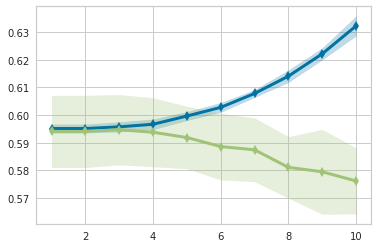


*Curva de Validação* -  A curva de validação é variada de acordo com os k-folds utilizados e é medido de acordo com a porcentagem do aprendizado gerado

## Pipeline para os Rastreamento dos Dados Kobe Bryant

**IMPORTANCIA DAS FERRAMENTAS NO RASTREAMENTO**

**Streamlit** - Não é utilizado nessa etapa

**MLFlow**  - É utilizado para a criação de APIs e a criação dos modelos desenvolvidos para o log, além disso é possivel utilizar através da API para outras bases

**PyCaret** - É utilizado para buscar as configurações dos dados que foram registrados nas etapas anteriores

**Scikit-Learn** - Não é utilizado nessa etapa

#### Servir Dados do Modelo

In [27]:
from mlflow.tracking import MlflowClient
mlflow.set_tracking_uri("sqlite:///../mlruns.db")

registered_model_name = 'modelo_kobe'
model_version = -1 # recuperar a ultima versao
nexamples = 4

In [28]:
# Assinatura do Modelo Inferida pelo MLFlow
model_features = list(df_kobe_2p.drop(kobe_target_col, axis=1).columns)
inf_signature = infer_signature(df_kobe_2p[model_features], model_pipe.predict(df_kobe_2p))
# Exemplo de entrada para o MLmodel
input_example = {x: df_kobe_2p[x].values[:nexamples] for x in model_features}
# Log do pipeline de modelagem do sklearn e registrar como uma nova versao

In [29]:
# Log do pipeline de modelagem do sklearn e registrar como uma nova versao
mlflow.sklearn.log_model(
     sk_model=model_pipe,
     artifact_path="sklearn-model",
     registered_model_name=registered_model_name,
     signature = inf_signature,
     input_example = input_example
 )
# Criacao do cliente do servico MLFlow e atualizacao versao modelo
client = MlflowClient()
if model_version == -1:
    model_version = client.get_latest_versions(registered_model_name)[-1].version
# Registrar o modelo como staging
client.transition_model_version_stage(
     name=registered_model_name,
     version=model_version, # Verificar com usuario qual versao
     stage="Staging"
)
mlflow.end_run()

Registered model 'modelo_kobe' already exists. Creating a new version of this model...
2022/10/04 00:25:13 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: modelo_kobe, version 6
Created version '6' of model 'modelo_kobe'.


In [32]:
import os
os.environ['MLFLOW_TRACKING_URI'] = 'sqlite:///../mlruns.db'
!mlflow models serve -m "models:/modelo_kobe/Staging" --no-conda -p 5002

^C


In [33]:
import requests
host = 'localhost'
port = '5002'
url = f'http://{host}:{port}/invocations'
headers = {'Content-Type': 'application/json'}

http_data = data_operation.drop(kobe_target_col,axis=1).to_json(orient='split')
r = requests.post(url=url, headers=headers, data=http_data)
data_operation.loc[:, 'operation_label'] = pd.read_json(r.text).values[:,0]
data_operation.to_parquet('../Data/Modeling/modelo_kobe_operacao.parquet')

In [34]:
print(metrics.classification_report(data_operation[kobe_target_col], data_operation['operation_label']))

              precision    recall  f1-score   support

         0.0       0.56      0.49      0.52      2105
         1.0       0.52      0.59      0.55      1952

    accuracy                           0.54      4057
   macro avg       0.54      0.54      0.53      4057
weighted avg       0.54      0.54      0.53      4057



#### Consumir o Serviço do Kobe Bryant

Este modelo é  relativamente aderente a base colocada pois varia o valor aumentando o acerto das bases a serem utilizadas

Entretanto as variaveis com o acerto das bolas de 3 pts não possui tanta acurácia por conta da viabilidade da variavel shot_distance pois há um valor muito diferente dos dados utilizados para o treinamento

In [35]:
!curl http://localhost:5002/invocations -X POST -H "Content-Type:application/json; format=pandas-split" --data "{\"columns\":[\"lat\", \"lon\", \"minutes_remaining\", \"period\",\"playoffs\",\"shot_distance\"],\"data\":[[35.9913,-120.3178,8,4,0,7],[33.9703,-118.2908,11,3,0,7]]}"

[0, 1]


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   156  100     6  100   150    150   3764 --:--:-- --:--:-- --:--:--  4105


In [37]:
http_data = df_kobe_3p.drop(kobe_target_col,axis=1).to_json(orient='split')
r = requests.post(url=url, headers=headers, data=http_data)

In [38]:
df_kobe_3p.loc[:, 'operation_label'] = pd.read_json(r.text).values[:,0]

print(metrics.classification_report(df_kobe_3p[kobe_target_col], df_kobe_3p['operation_label']))

              precision    recall  f1-score   support

         0.0       0.67      0.68      0.68      3630
         1.0       0.34      0.33      0.33      1782

    accuracy                           0.57      5412
   macro avg       0.51      0.51      0.51      5412
weighted avg       0.56      0.57      0.56      5412



In [40]:
df_kobe_3p[kobe_target_col].value_counts()

0.0    3630
1.0    1782
Name: shot_made_flag, dtype: int64

In [41]:
df_kobe_3p['operation_label'].value_counts()

1    2755
0    2657
Name: operation_label, dtype: int64

In [42]:
import requests
host = 'localhost'
port = '5002'
url = f'http://{host}:{port}/invocations'
headers = {'Content-Type': 'application/json'}

http_data = data_operation.drop(kobe_target_col,axis=1).to_json(orient='split')
r = requests.post(url=url, headers=headers, data=http_data)

In [43]:
!curl http://localhost:5002/invocations -X POST -H "Content-Type:application/json; format=pandas-split" --data "{\"columns\":[\"lat\", \"lon\", \"minutes_remaining\", \"period\",\"playoffs\",\"shot_distance\"],\"data\":[[35.9913,-120.3178,8,4,0,7],[33.9703,-118.2908,11,3,0,7]]}"

[1, 1]


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   156  100     6  100   150     82   2071 --:--:-- --:--:-- --:--:--  2197


In [39]:
http_data = df_kobe_3p.drop(kobe_target_col,axis=1).to_json(orient='split')
r = requests.post(url=url, headers=headers, data=http_data)

In [40]:
df_kobe_3p.loc[:, 'operation_label'] = pd.read_json(r.text).values[:,0]

In [41]:
print(metrics.classification_report(df_kobe_3p[kobe_target_col], df_kobe_3p['operation_label']))

              precision    recall  f1-score   support

         0.0       0.67      0.68      0.68      3630
         1.0       0.34      0.33      0.33      1782

    accuracy                           0.57      5412
   macro avg       0.51      0.51      0.51      5412
weighted avg       0.56      0.57      0.56      5412



In [48]:
df_kobe_3p['operation_label'].value_counts()

1    2755
0    2657
Name: operation_label, dtype: int64

## Pipeline para os Monitoramento dos Dados Kobe Bryant

**IMPORTANCIA DAS FERRAMENTAS NO MONITORAMENTO**

O Monitoramento dos dados é feito caso haja mais de uma acurácia de 50% e é possivel revalidar 
de acordo com uma amostra de 150

**Streamlit** - Não é utilizado no monitoramento dos dados

**MLFlow**  - É utilizado para registrar os experimentos e treinamentos da base dos dados para comparar na aprovação dos dados e recuperar os dados do modelo. Além de gravar os dados colocados no modelo

**PyCaret** - Auxilia para fazer a predição dos modelos resgatados pelo Mlflow além das configurações utilizadas nos modelos.

**Scikit-Learn** - É utilizado para fazer os calculos das métricas dos modelos selecionados

### Aprovação dos Modelos

In [43]:
min_accuracy = 0.5
model_version = -1 # recuperar a ultima versao

In [44]:
# COLOCAR RUN APROVACAO DE MODELO
# PARAMETROS: min_accuracy
# METRICS: new_version, accuracy
# ARTIFACTS: None


with mlflow.start_run(experiment_id=experiment_id, run_name = 'AprovacaoModelo'):
    pred_holdout = pc.predict_model(bestmodel[0])
    acc = metrics.accuracy_score(pred_holdout[kobe_target_col], pred_holdout['Label'])
    if acc > min_precision:
        print(f'=> Aceito o modelo com precisão {acc} (min: {min_accuracy})')
        pred_holdout.to_parquet('../Data/Processed/modelo_kobe_teste.parquet')
        # Assinatura do Modelo Inferida pelo MLFlow
        model_features = list(df_kobe.drop(kobe_target_col, axis=1).columns)
        inf_signature = infer_signature(df_kobe[model_features], model_pipe.predict(df_kobe))
        # Exemplo de entrada para o MLmodel
        input_example = {x: df_kobe[x].values[:nexamples] for x in model_features}
        # Log do pipeline de modelagem do sklearn e registrar como uma nova versao
        mlflow.sklearn.log_model(
            sk_model=model_pipe,
            artifact_path="sklearn-model",
            registered_model_name=registered_model_name,
            signature = inf_signature,
            input_example = input_example
        )
        # Criacao do cliente do servico MLFlow e atualizacao versao modelo
        client = MlflowClient()
        if model_version == -1:
            model_version = client.get_latest_versions(registered_model_name)[-1].version
        # Registrar o modelo como staging
        client.transition_model_version_stage(
            name=registered_model_name,
            version=model_version, # Verificar com usuario qual versao
            stage="Staging"
        )
    else:
        print(f'=> Rejeitado o modelo com precisão {acc} (min: {min_accuracy})')

    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("precisao_minima", min_accuracy)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("new_version", model_version)
    mlflow.log_metric("accuracy", acc)

mlflow.end_run()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Log Loss
0,Decision Tree Classifier,0.5354,0.5101,0.5861,0.5151,0.5483,0.0741,0.0747,16.0479


=> Rejeitado o modelo com precisão 0.5353709637663298 (min: 0.5)


### Revalidacao de Amostras para Monitoramento

In [46]:
# COLOCAR RUN REVALIDACAO
# PARAMETROS: min_samples_control
# METRICS: matriz de confusao
# ARTIFACTS:


# Utilizacao da amostra de controle, que teria sido reavaliada por especialistas
min_samples_control = 150

with mlflow.start_run(experiment_id=experiment_id, run_name = 'RevalidacaoOperacao'):

    data_operation = pd.read_parquet('../Data/Modeling/modelo_kobe_operacao.parquet')

    data_control = data_operation.sample(min_samples_control, random_state=SEED)
    data_control.to_parquet('../Data/Processed/modelo_kobe_controle.parquet')

    print('== DADOS DE CONTROLE ==')
    print(metrics.classification_report(data_control[kobe_target_col], data_control['operation_label']))
    
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_samples_control", min_samples_control)

    # LOG DE METRICAS GLOBAIS
    cm = metrics.confusion_matrix(data_control[kobe_target_col], data_control['operation_label'])
    specificity = cm[0,0] / cm.sum(axis=1)[0]
    sensibility = cm[1,1] / cm.sum(axis=1)[1]
    precision   = cm[1,1] / cm.sum(axis=0)[1]
    mlflow.log_metric("Especificidade", specificity)
    mlflow.log_metric("Sensibilidade", sensibility)
    mlflow.log_metric("Precisao", precision)

mlflow.end_run()

== DADOS DE CONTROLE ==
              precision    recall  f1-score   support

         0.0       0.61      0.43      0.50        79
         1.0       0.52      0.69      0.59        71

    accuracy                           0.55       150
   macro avg       0.56      0.56      0.55       150
weighted avg       0.57      0.55      0.55       150



### Alarme de Desvio

In [49]:
# reset matplotlib

mpl.rcParams.update(inline_rc)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
mpl.rc('font', **font)
lines = {'linewidth' : 3}
mpl.rc('lines', **lines)

def data_drift_alarm(var_name, dev_data, data_test, data_control):    
    sn.kdeplot(dev_data[var_name], label='Desenvolvimento')
    sn.kdeplot(data_test[var_name], label='Teste')
    sn.kdeplot(data_control[var_name], label='Monitoramento')
    plt.grid()
    plt.legend(loc='best')
    plt.title(f'Distribuição Variável {var_name}')
    plt.ylabel('Distancia')
    plt.xlabel(f'Unidade de {var_name}')
    plt.tight_layout()

### Alarme de Retreinamento

In [47]:
def alarm(data_monitoring, testset, min_eff_alarm):
    cm = metrics.confusion_matrix(data_monitoring[kobe_target_col], data_monitoring['operation_label'])
    specificity_m = cm[0,0] / cm.sum(axis=1)[0]
    sensibility_m = cm[1,1] / cm.sum(axis=1)[1]
    precision_m   = cm[1,1] / cm.sum(axis=0)[1]

    cm = metrics.confusion_matrix(testset[kobe_target_col], testset['Label'])
    specificity_t = cm[0,0] / cm.sum(axis=1)[0]
    sensibility_t = cm[1,1] / cm.sum(axis=1)[1]
    precision_t   = cm[1,1] / cm.sum(axis=0)[1]

    retrain = False
    for name, metric_m, metric_t in zip(['especificidade', 'sensibilidade', 'precisao'],
                                        [specificity_m, sensibility_m, precision_m],
                                        [specificity_t, sensibility_t, precision_t]):
        
        print(f'\t=> {name} de teste {metric_t} e de controle {metric_m}')
        if (metric_t-metric_m)/metric_t > min_eff_alarm:
            print(f'\t=> MODELO OPERANDO FORA DO ESPERADO')
            retrain = True
        else:
            print(f'\t=> MODELO OPERANDO DENTRO DO ESPERADO')
           
        
    return (retrain, [specificity_m, sensibility_m, precision_m],
                                        [specificity_t, sensibility_t, precision_t] ) 

### Monitoramento Base Operação

== ALARME DE RETREINAMENTO - BASE CONTROLE ==
	=> especificidade de teste 0.4883610451306413 e de controle 0.43037974683544306
	=> MODELO OPERANDO FORA DO ESPERADO
	=> sensibilidade de teste 0.5860655737704918 e de controle 0.6901408450704225
	=> MODELO OPERANDO DENTRO DO ESPERADO
	=> precisao de teste 0.515083295812697 e de controle 0.5212765957446809
	=> MODELO OPERANDO DENTRO DO ESPERADO
==> RETREINAMENTO NECESSARIO


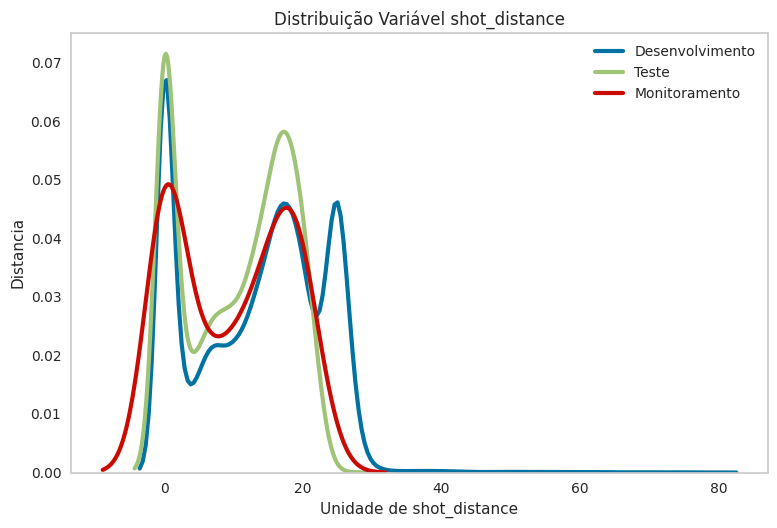

In [50]:
# COLOCAR RUN MONITORAMENTO OPERACAO
# PARAMETROS: min_eff_alarm
# METRICS: metricas avaliadas e de referencia
# ARTIFACTS:

print('== ALARME DE RETREINAMENTO - BASE CONTROLE ==')
# 10% de desvio aceitavel na metrica. Deve ser estimado pelo conjunto de validacao cruzada. 
min_eff_alarm = 0.1 

with mlflow.start_run(experiment_id=experiment_id, run_name = 'MonitoramentoOperacao'):
    data_control = pd.read_parquet('../Data/Processed/modelo_kobe_controle.parquet')
    
    (retrain, [specificity_m, sensibility_m, precision_m],
              [specificity_t, sensibility_t, precision_t] ) = alarm(data_control, pred_holdout, min_eff_alarm)
    if retrain:
        print('==> RETREINAMENTO NECESSARIO')
    else:
        print('==> RETREINAMENTO NAO NECESSARIO')
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_eff_alarm", min_eff_alarm)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("Alarme Retreino", float(retrain))
    mlflow.log_metric("Especificidade Controle", specificity_m)
    mlflow.log_metric("Sensibilidade Controle", sensibility_m)
    mlflow.log_metric("Precisao Controle", precision_m)
    mlflow.log_metric("Especificidade Teste", specificity_t)
    mlflow.log_metric("Sensibilidade Teste", sensibility_t)
    mlflow.log_metric("Precisao Teste", precision_t)
    
    # LOG ARTEFATO
    var_name = 'shot_distance' # 'alcohol'
    data_drift_alarm(var_name, df_kobe, pred_holdout, data_control)
    plot_path = f'monitor_datadrift_{var_name}.png'
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)
    

mlflow.end_run()  

## Pipeline para a Atualização dos Dados Kobe Bryant

**IMPORTANCIA DAS FERRAMENTAS NA ATUALIZAÇÃO**

É verificado a quantidade de acurácia do modelo e avaliado os dados do controle e caso tenha o valor necessário não é necessário de acordo com os valores deve ser feito o treinamento novamente

**Streamlit** - Não é utilizado nessa etapa

**MLFlow**  - É utilizado para a criação de APIs e a criação dos modelos desenvolvidos para o log, além disso é possivel utilizar através da API para outras bases

**PyCaret** - Criação de artefatos e grava parametros e metricas 

**Scikit-Learn** - Faz o carregamento do modelo dos dados gravados no Mlflow

### Monitoramento Base de Novidade

== ALARME DE RETREINAMENTO - BASE NOVIDADE ==
	=> especificidade de teste 0.48660084626234135 e de controle 0.7038567493112947
	=> MODELO OPERANDO DENTRO DO ESPERADO
	=> sensibilidade de teste 0.5880829015544041 e de controle 0.31257014590347926
	=> MODELO OPERANDO FORA DO ESPERADO
	=> precisao de teste 0.50965424337674 e de controle 0.34129901960784315
	=> MODELO OPERANDO FORA DO ESPERADO
==> RETREINAMENTO NECESSARIO


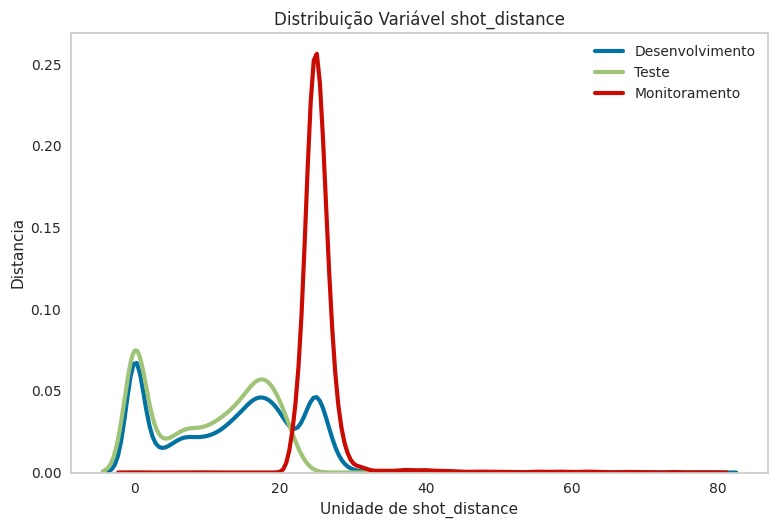

In [60]:
# COLOCAR RUN MONITORAMENTO NOVIDADE
# PARAMETROS: min_eff_alarm
# METRICS: metricas avaliadas e de referencia
# ARTIFACTS:

print('== ALARME DE RETREINAMENTO - BASE NOVIDADE ==')
# 10% de desvio aceitavel na metrica. Deve ser estimado pelo conjunto de validacao cruzada. 
min_eff_alarm = 0.1 

with mlflow.start_run(experiment_id=experiment_id, run_name = 'MonitoramentoNovidade'):

    model_uri = f"models:/modelo_kobe/Staging"
    loaded_model = mlflow.sklearn.load_model(model_uri)
    data_novelty = pd.read_parquet('../Data/Processed/base_kobe_novidade.parquet')
    data_novelty.loc[:, 'operation_label'] = loaded_model.predict(data_novelty)
    
    (retrain, [specificity_m, sensibility_m, precision_m],
              [specificity_t, sensibility_t, precision_t] ) = alarm(data_novelty, pred_holdout, min_eff_alarm)
    if retrain:
        print('==> RETREINAMENTO NECESSARIO')
    else:
        print('==> RETREINAMENTO NAO NECESSARIO')
    # LOG DE PARAMETROS DO MODELO
    mlflow.log_param("min_eff_alarm", min_eff_alarm)

    # LOG DE METRICAS GLOBAIS
    mlflow.log_metric("Alarme Retreino", float(retrain))
    mlflow.log_metric("Especificidade Controle", specificity_m)
    mlflow.log_metric("Sensibilidade Controle", sensibility_m)
    mlflow.log_metric("Precisao Controle", precision_m)
    mlflow.log_metric("Especificidade Teste", specificity_t)
    mlflow.log_metric("Sensibilidade Teste", sensibility_t)
    mlflow.log_metric("Precisao Teste", precision_t)
    # LOG ARTEFATO
    var_name = 'shot_distance' # 'alcohol'
    data_drift_alarm(var_name, df_kobe, pred_holdout, data_novelty)
    plot_path = f'novidade_datadrift_{var_name}.png'
    plt.savefig(plot_path)
    mlflow.log_artifact(plot_path)

mlflow.end_run()  

## Pipeline para o Provisionamento dos Dados Kobe Bryant

**IMPORTANCIA DAS FERRAMENTAS NO PROVISIONAMENTO**

**Streamlit** - Não é utilizado nessa etapa

**MLFlow**  - É utilizado para a transição do modelo para a produção

**PyCaret** - Não é utilizado nessa etapa

**Scikit-Learn** - Não é utilizado nessa etapa

In [57]:
# Log do pipeline de modelagem do sklearn e registrar como uma nova versao
mlflow.sklearn.log_model(
     sk_model=model_pipe,
     artifact_path="sklearn-model",
     registered_model_name=registered_model_name,
     signature = inf_signature,
     input_example = input_example
 )
# Criacao do cliente do servico MLFlow e atualizacao versao modelo
client = MlflowClient()
if model_version == -1:
    model_version = 2
# Registrar o modelo como staging
client.transition_model_version_stage(
     name=registered_model_name,
     version=2, # Verificar com usuario qual versao
     stage="Production"
)
mlflow.end_run()

Registered model 'modelo_kobe' already exists. Creating a new version of this model...
2022/09/20 14:34:01 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: modelo_kobe, version 5
Created version '5' of model 'modelo_kobe'.


## Dashboard de Monitoramento

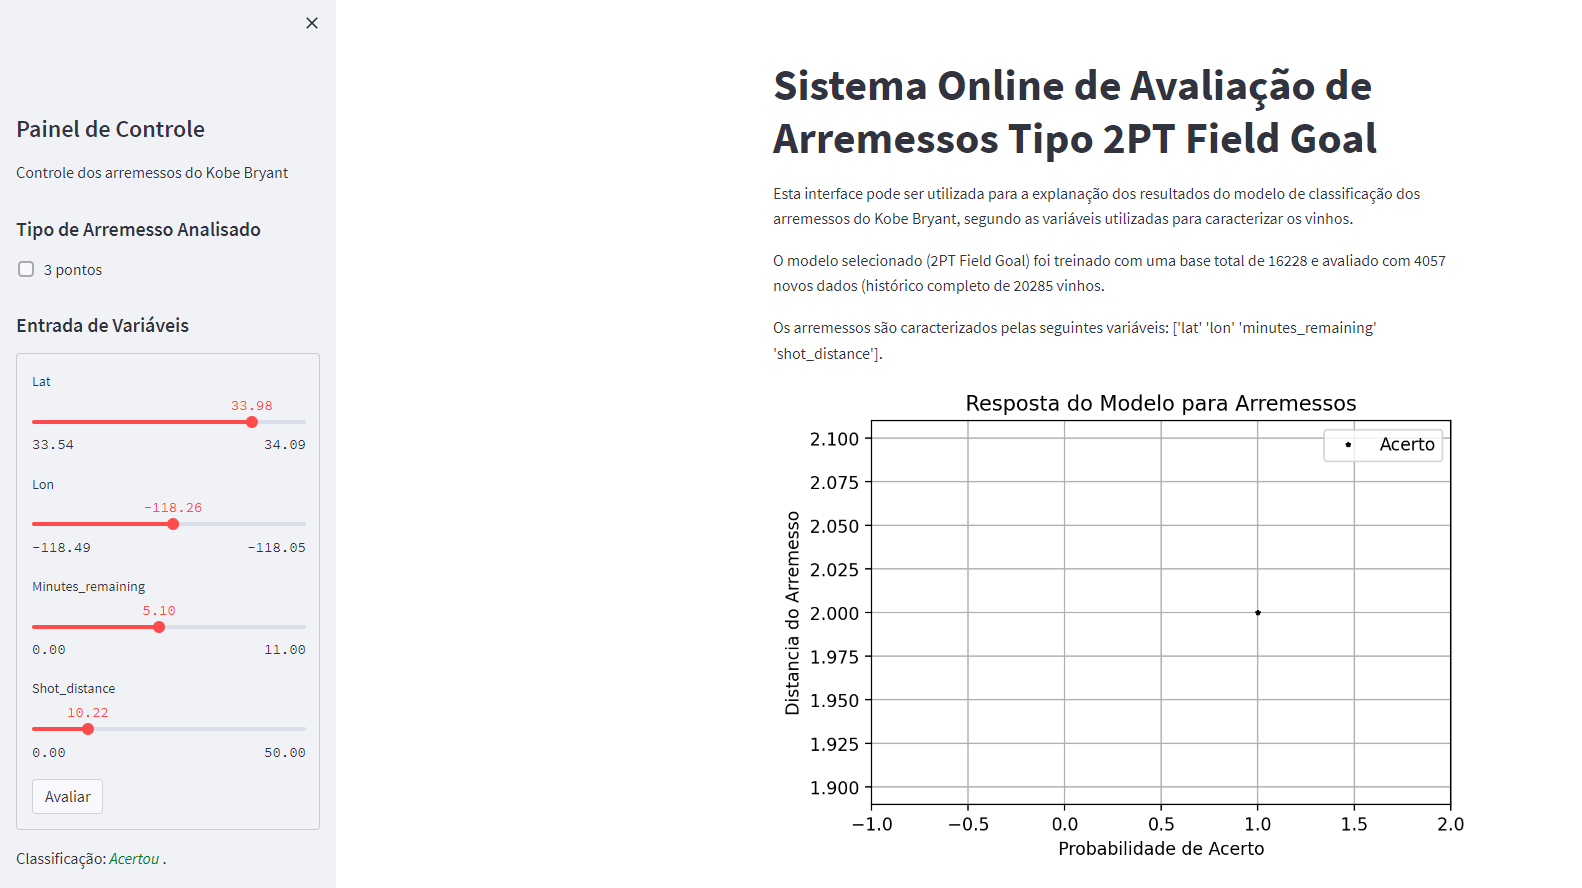